## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2023-11-29 13:29:53--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.163.125, 52.216.54.104, 16.182.106.80, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.163.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.2’

train-test-data.zip 100%[===================>] 322.93M  40.8MB/s    in 7.8s    

2023-11-29 13:30:01 (41.4 MB/s) - ‘/data/train-test-data.zip.2’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import NaimishNet
from models import NaimishResidualNet, NaimishResidualNet_mini, ResidualBlock
from models import ResNet, BasicBlock

# net = NaimishNet().to(device)
net = NaimishResidualNet().to(device)
# net = NaimishResidualNet_mini().to(device)
# net = ResNet(BasicBlock, [3, 4, 6, 3]).to(device)

print(net)

Using cuda device
NaimishResidualNet(
  (avgpool): AdaptiveAvgPool2d(output_size=(96, 96))
  (conv1): ResidualBlock(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3))
    (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3))
    (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv1x1): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1), padding=(3, 3))
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1)
  (conv2): ResidualBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv1x1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  )
  (maxpool2): MaxPool

In [4]:
! pip install torchsummary

In [5]:
from torchsummary import summary
summary(net,(1,224,224)) # summary(model,(channels,H,W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
 AdaptiveAvgPool2d-1            [-1, 1, 96, 96]               0
            Conv2d-2           [-1, 32, 99, 99]             544
       BatchNorm2d-3           [-1, 32, 99, 99]              64
              ReLU-4           [-1, 32, 99, 99]               0
            Conv2d-5         [-1, 32, 102, 102]          16,416
       BatchNorm2d-6         [-1, 32, 102, 102]              64
            Conv2d-7         [-1, 32, 102, 102]              64
       BatchNorm2d-8         [-1, 32, 102, 102]              64
              ReLU-9         [-1, 32, 102, 102]               0
    ResidualBlock-10         [-1, 32, 102, 102]               0
        MaxPool2d-11           [-1, 32, 51, 51]               0
          Dropout-12           [-1, 32, 51, 51]               0
           Conv2d-13           [-1, 64, 53, 53]          18,496
      BatchNorm2d-14           [-1, 64,

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250), 
                                     RandomCrop(224), 
                                     Normalize(), 
                                     ToTensor()])


# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [7]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [8]:
# load training data in batches
batch_size = 32 #10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [9]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [10]:
# load test data in batches
batch_size = 32 #10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [11]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor).to(device)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [12]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [13]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

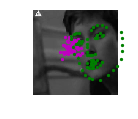

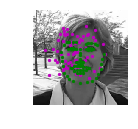

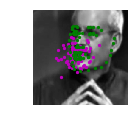

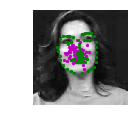

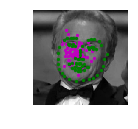

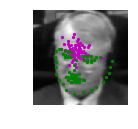

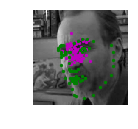

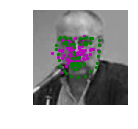

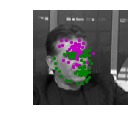

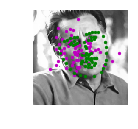

In [14]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.cpu().numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [15]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(params = net.parameters(), lr = 0.001, betas=(0.9, 0.999), eps=1e-08) 


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [16]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor).to(device)
            images = images.type(torch.FloatTensor).to(device)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [18]:
# train your network
n_epochs = 5 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.10307131670415401
Epoch: 1, Batch: 20, Avg. Loss: 0.07511777877807617
Epoch: 1, Batch: 30, Avg. Loss: 0.12496520131826401
Epoch: 1, Batch: 40, Avg. Loss: 0.07777755595743656
Epoch: 1, Batch: 50, Avg. Loss: 0.08512579575181008
Epoch: 1, Batch: 60, Avg. Loss: 0.07536125481128693
Epoch: 1, Batch: 70, Avg. Loss: 0.08515719063580036
Epoch: 1, Batch: 80, Avg. Loss: 0.06965369582176209
Epoch: 1, Batch: 90, Avg. Loss: 0.09137766771018505
Epoch: 1, Batch: 100, Avg. Loss: 0.07535343244671822


/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.07986939772963524
Epoch: 2, Batch: 20, Avg. Loss: 0.07547300793230534
Epoch: 2, Batch: 30, Avg. Loss: 0.08298794403672219
Epoch: 2, Batch: 40, Avg. Loss: 0.06329664438962937
Epoch: 2, Batch: 50, Avg. Loss: 0.07050882689654828
Epoch: 2, Batch: 60, Avg. Loss: 0.10995192527770996
Epoch: 2, Batch: 70, Avg. Loss: 0.06476775109767914
Epoch: 2, Batch: 80, Avg. Loss: 0.08506291508674621
Epoch: 2, Batch: 90, Avg. Loss: 0.10780777335166931
Epoch: 2, Batch: 100, Avg. Loss: 0.05581477396190167


/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.07551797404885292
Epoch: 3, Batch: 20, Avg. Loss: 0.06800346113741398
Epoch: 3, Batch: 30, Avg. Loss: 0.07593740746378899
Epoch: 3, Batch: 40, Avg. Loss: 0.05805340148508549
Epoch: 3, Batch: 50, Avg. Loss: 0.054802754893898964
Epoch: 3, Batch: 60, Avg. Loss: 0.11687514036893845
Epoch: 3, Batch: 70, Avg. Loss: 0.07356376945972443
Epoch: 3, Batch: 80, Avg. Loss: 0.08047143630683422
Epoch: 3, Batch: 90, Avg. Loss: 0.07170731462538242
Epoch: 3, Batch: 100, Avg. Loss: 0.062355969473719595


/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.06620121151208877
Epoch: 4, Batch: 20, Avg. Loss: 0.10906596146523953
Epoch: 4, Batch: 30, Avg. Loss: 0.06963036321103573
Epoch: 4, Batch: 40, Avg. Loss: 0.06783092953264713
Epoch: 4, Batch: 50, Avg. Loss: 0.08512566424906254
Epoch: 4, Batch: 60, Avg. Loss: 0.06739003770053387
Epoch: 4, Batch: 70, Avg. Loss: 0.06351704150438309
Epoch: 4, Batch: 80, Avg. Loss: 0.06813844107091427
Epoch: 4, Batch: 90, Avg. Loss: 0.06774455271661281
Epoch: 4, Batch: 100, Avg. Loss: 0.0699438612908125


/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.05800739638507366
Epoch: 5, Batch: 20, Avg. Loss: 0.1118950393050909
Epoch: 5, Batch: 30, Avg. Loss: 0.056542377918958664
Epoch: 5, Batch: 40, Avg. Loss: 0.06411811299622058
Epoch: 5, Batch: 50, Avg. Loss: 0.07605723068118095
Epoch: 5, Batch: 60, Avg. Loss: 0.09002729058265686
Epoch: 5, Batch: 70, Avg. Loss: 0.06874070093035697
Epoch: 5, Batch: 80, Avg. Loss: 0.05191822573542595
Epoch: 5, Batch: 90, Avg. Loss: 0.05905547775328159
Epoch: 5, Batch: 100, Avg. Loss: 0.05769037641584873
Finished Training


In [19]:
# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.06904252506792545
Epoch: 1, Batch: 20, Avg. Loss: 0.06562524400651455
Epoch: 1, Batch: 30, Avg. Loss: 0.08594539128243923
Epoch: 1, Batch: 40, Avg. Loss: 0.07795146405696869
Epoch: 1, Batch: 50, Avg. Loss: 0.054841355234384534
Epoch: 1, Batch: 60, Avg. Loss: 0.06526366956532001
Epoch: 1, Batch: 70, Avg. Loss: 0.06987713389098645
Epoch: 1, Batch: 80, Avg. Loss: 0.05986935943365097
Epoch: 1, Batch: 90, Avg. Loss: 0.06203123405575752
Epoch: 1, Batch: 100, Avg. Loss: 0.055101491138339044


/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.06873685903847218
Epoch: 2, Batch: 20, Avg. Loss: 0.0652985405176878
Epoch: 2, Batch: 30, Avg. Loss: 0.05789225958287716
Epoch: 2, Batch: 40, Avg. Loss: 0.05711073875427246
Epoch: 2, Batch: 50, Avg. Loss: 0.05440779998898506
Epoch: 2, Batch: 60, Avg. Loss: 0.04708916991949082
Epoch: 2, Batch: 70, Avg. Loss: 0.06409416869282722
Epoch: 2, Batch: 80, Avg. Loss: 0.06015426069498062
Epoch: 2, Batch: 90, Avg. Loss: 0.06795319207012654
Epoch: 2, Batch: 100, Avg. Loss: 0.05431706495583057


/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.05855787545442581
Epoch: 3, Batch: 20, Avg. Loss: 0.06016167476773262
Epoch: 3, Batch: 30, Avg. Loss: 0.05823983699083328
Epoch: 3, Batch: 40, Avg. Loss: 0.05917128771543503
Epoch: 3, Batch: 50, Avg. Loss: 0.1000267393887043
Epoch: 3, Batch: 60, Avg. Loss: 0.06925815604627132
Epoch: 3, Batch: 70, Avg. Loss: 0.07462088242173195
Epoch: 3, Batch: 80, Avg. Loss: 0.08383433930575848
Epoch: 3, Batch: 90, Avg. Loss: 0.05086982809007168
Epoch: 3, Batch: 100, Avg. Loss: 0.07243560142815113


/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.047067878767848015
Epoch: 4, Batch: 20, Avg. Loss: 0.0554630246013403
Epoch: 4, Batch: 30, Avg. Loss: 0.0720432948321104
Epoch: 4, Batch: 40, Avg. Loss: 0.049665478989481926
Epoch: 4, Batch: 50, Avg. Loss: 0.047883447632193564
Epoch: 4, Batch: 60, Avg. Loss: 0.04929328821599484
Epoch: 4, Batch: 70, Avg. Loss: 0.06341023929417133
Epoch: 4, Batch: 80, Avg. Loss: 0.0675962932407856
Epoch: 4, Batch: 90, Avg. Loss: 0.05856737121939659
Epoch: 4, Batch: 100, Avg. Loss: 0.07249699197709561


/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.05085446313023567
Epoch: 5, Batch: 20, Avg. Loss: 0.08888867199420929
Epoch: 5, Batch: 30, Avg. Loss: 0.04884515441954136
Epoch: 5, Batch: 40, Avg. Loss: 0.05780043676495552
Epoch: 5, Batch: 50, Avg. Loss: 0.05678757652640343
Epoch: 5, Batch: 60, Avg. Loss: 0.051774995401501656
Epoch: 5, Batch: 70, Avg. Loss: 0.06715926267206669
Epoch: 5, Batch: 80, Avg. Loss: 0.060139724612236024
Epoch: 5, Batch: 90, Avg. Loss: 0.0528743464499712
Epoch: 5, Batch: 100, Avg. Loss: 0.04428837914019823
Finished Training


In [20]:
# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.052019717544317244
Epoch: 1, Batch: 20, Avg. Loss: 0.04781644456088543
Epoch: 1, Batch: 30, Avg. Loss: 0.042872562631964685
Epoch: 1, Batch: 40, Avg. Loss: 0.04434511307626963
Epoch: 1, Batch: 50, Avg. Loss: 0.050813508406281474
Epoch: 1, Batch: 60, Avg. Loss: 0.04789431877434254
Epoch: 1, Batch: 70, Avg. Loss: 0.048896186798810956
Epoch: 1, Batch: 80, Avg. Loss: 0.04340324178338051
Epoch: 1, Batch: 90, Avg. Loss: 0.06247056350111961
Epoch: 1, Batch: 100, Avg. Loss: 0.04679112359881401


/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.048172279819846155
Epoch: 2, Batch: 20, Avg. Loss: 0.05199520066380501
Epoch: 2, Batch: 30, Avg. Loss: 0.04400728791952133
Epoch: 2, Batch: 40, Avg. Loss: 0.03980604112148285
Epoch: 2, Batch: 50, Avg. Loss: 0.044042509980499744
Epoch: 2, Batch: 60, Avg. Loss: 0.04708691779524088
Epoch: 2, Batch: 70, Avg. Loss: 0.04419612251222134
Epoch: 2, Batch: 80, Avg. Loss: 0.04139939993619919
Epoch: 2, Batch: 90, Avg. Loss: 0.0924833059310913
Epoch: 2, Batch: 100, Avg. Loss: 0.04730086624622345


/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.06629414446651935
Epoch: 3, Batch: 20, Avg. Loss: 0.047113948315382
Epoch: 3, Batch: 30, Avg. Loss: 0.041111629083752634
Epoch: 3, Batch: 40, Avg. Loss: 0.04337387531995773
Epoch: 3, Batch: 50, Avg. Loss: 0.04512645956128836
Epoch: 3, Batch: 60, Avg. Loss: 0.04798887297511101
Epoch: 3, Batch: 70, Avg. Loss: 0.05029264055192471
Epoch: 3, Batch: 80, Avg. Loss: 0.07905078418552876
Epoch: 3, Batch: 90, Avg. Loss: 0.07952410764992238
Epoch: 3, Batch: 100, Avg. Loss: 0.06577429659664631


/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.04630092084407807
Epoch: 4, Batch: 20, Avg. Loss: 0.04466387815773487
Epoch: 4, Batch: 30, Avg. Loss: 0.04118754621595144
Epoch: 4, Batch: 40, Avg. Loss: 0.12690814211964607
Epoch: 4, Batch: 50, Avg. Loss: 0.0634128600358963
Epoch: 4, Batch: 60, Avg. Loss: 0.046511690504848956
Epoch: 4, Batch: 70, Avg. Loss: 0.06617243140935898
Epoch: 4, Batch: 80, Avg. Loss: 0.05348895378410816
Epoch: 4, Batch: 90, Avg. Loss: 0.05143120028078556
Epoch: 4, Batch: 100, Avg. Loss: 0.05658606551587582


/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.04595917332917452
Epoch: 5, Batch: 20, Avg. Loss: 0.04550631232559681
Epoch: 5, Batch: 30, Avg. Loss: 0.04920178595930338
Epoch: 5, Batch: 40, Avg. Loss: 0.04130420312285423
Epoch: 5, Batch: 50, Avg. Loss: 0.046957357600331304
Epoch: 5, Batch: 60, Avg. Loss: 0.04399660062044859
Epoch: 5, Batch: 70, Avg. Loss: 0.04508172236382961
Epoch: 5, Batch: 80, Avg. Loss: 0.08091496303677559
Epoch: 5, Batch: 90, Avg. Loss: 0.055026284605264666
Epoch: 5, Batch: 100, Avg. Loss: 0.10666219294071197
Finished Training


In [21]:
# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.04618491195142269
Epoch: 1, Batch: 20, Avg. Loss: 0.07104023844003678
Epoch: 1, Batch: 30, Avg. Loss: 0.04589863196015358
Epoch: 1, Batch: 40, Avg. Loss: 0.08927582912147045
Epoch: 1, Batch: 50, Avg. Loss: 0.04878882467746735
Epoch: 1, Batch: 60, Avg. Loss: 0.06299456134438515
Epoch: 1, Batch: 70, Avg. Loss: 0.04500899612903595
Epoch: 1, Batch: 80, Avg. Loss: 0.03952516242861748
Epoch: 1, Batch: 90, Avg. Loss: 0.04245678223669529
Epoch: 1, Batch: 100, Avg. Loss: 0.05167920589447021


/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.06419820599257946
Epoch: 2, Batch: 20, Avg. Loss: 0.0448239803314209
Epoch: 2, Batch: 30, Avg. Loss: 0.0713915292173624
Epoch: 2, Batch: 40, Avg. Loss: 0.05940669141709805
Epoch: 2, Batch: 50, Avg. Loss: 0.042991301789879796
Epoch: 2, Batch: 60, Avg. Loss: 0.04636803567409516
Epoch: 2, Batch: 70, Avg. Loss: 0.0493902787566185
Epoch: 2, Batch: 80, Avg. Loss: 0.04149232618510723
Epoch: 2, Batch: 90, Avg. Loss: 0.04195051416754723
Epoch: 2, Batch: 100, Avg. Loss: 0.048719949834048745


/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.03701347578316927
Epoch: 3, Batch: 20, Avg. Loss: 0.06370524242520333
Epoch: 3, Batch: 30, Avg. Loss: 0.03401724807918072
Epoch: 3, Batch: 40, Avg. Loss: 0.04879443328827619
Epoch: 3, Batch: 50, Avg. Loss: 0.05826727766543627
Epoch: 3, Batch: 60, Avg. Loss: 0.052669393830001354
Epoch: 3, Batch: 70, Avg. Loss: 0.05549544207751751
Epoch: 3, Batch: 80, Avg. Loss: 0.043144648894667625
Epoch: 3, Batch: 90, Avg. Loss: 0.0710666123777628
Epoch: 3, Batch: 100, Avg. Loss: 0.03525417987257242


/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.08037012629210949
Epoch: 4, Batch: 20, Avg. Loss: 0.05076975785195827
Epoch: 4, Batch: 30, Avg. Loss: 0.040962368436157706
Epoch: 4, Batch: 40, Avg. Loss: 0.04104257225990295
Epoch: 4, Batch: 50, Avg. Loss: 0.04192628562450409
Epoch: 4, Batch: 60, Avg. Loss: 0.0446367522701621
Epoch: 4, Batch: 70, Avg. Loss: 0.03817438893020153
Epoch: 4, Batch: 80, Avg. Loss: 0.046786758489906786
Epoch: 4, Batch: 90, Avg. Loss: 0.039916970580816266
Epoch: 4, Batch: 100, Avg. Loss: 0.03831879161298275


/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.03819486703723669
Epoch: 5, Batch: 20, Avg. Loss: 0.04651693198829889
Epoch: 5, Batch: 30, Avg. Loss: 0.04323185551911592
Epoch: 5, Batch: 40, Avg. Loss: 0.04149333946406841
Epoch: 5, Batch: 50, Avg. Loss: 0.036056583561003205
Epoch: 5, Batch: 60, Avg. Loss: 0.03867076188325882
Epoch: 5, Batch: 70, Avg. Loss: 0.03587338887155056
Epoch: 5, Batch: 80, Avg. Loss: 0.03766112085431814
Epoch: 5, Batch: 90, Avg. Loss: 0.03464955072849989
Epoch: 5, Batch: 100, Avg. Loss: 0.045360043086111544
Finished Training


In [22]:
# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.05121913347393274
Epoch: 1, Batch: 20, Avg. Loss: 0.03763053845614195
Epoch: 1, Batch: 30, Avg. Loss: 0.05632992181926966
Epoch: 1, Batch: 40, Avg. Loss: 0.039155669137835504
Epoch: 1, Batch: 50, Avg. Loss: 0.03747770991176367
Epoch: 1, Batch: 60, Avg. Loss: 0.054101056233048436
Epoch: 1, Batch: 70, Avg. Loss: 0.03508809544146061
Epoch: 1, Batch: 80, Avg. Loss: 0.03492943532764912
Epoch: 1, Batch: 90, Avg. Loss: 0.03502154499292374
Epoch: 1, Batch: 100, Avg. Loss: 0.04646703582257032


/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.03393194638192654
Epoch: 2, Batch: 20, Avg. Loss: 0.03487294055521488
Epoch: 2, Batch: 30, Avg. Loss: 0.06450776197016239
Epoch: 2, Batch: 40, Avg. Loss: 0.04530779104679823
Epoch: 2, Batch: 50, Avg. Loss: 0.049305882677435874
Epoch: 2, Batch: 60, Avg. Loss: 0.07518431395292283
Epoch: 2, Batch: 70, Avg. Loss: 0.07384760528802872
Epoch: 2, Batch: 80, Avg. Loss: 0.03652414046227932
Epoch: 2, Batch: 90, Avg. Loss: 0.03427947796881199
Epoch: 2, Batch: 100, Avg. Loss: 0.03508308883756399


/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.05077176932245493
Epoch: 3, Batch: 20, Avg. Loss: 0.058943089470267294
Epoch: 3, Batch: 30, Avg. Loss: 0.04812564849853516
Epoch: 3, Batch: 40, Avg. Loss: 0.03658318966627121
Epoch: 3, Batch: 50, Avg. Loss: 0.06261177323758602
Epoch: 3, Batch: 60, Avg. Loss: 0.03241657074540853
Epoch: 3, Batch: 70, Avg. Loss: 0.03430501390248537
Epoch: 3, Batch: 80, Avg. Loss: 0.04542322922497988
Epoch: 3, Batch: 90, Avg. Loss: 0.058567602559924124
Epoch: 3, Batch: 100, Avg. Loss: 0.03899742066860199


/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.08639873303472996
Epoch: 4, Batch: 20, Avg. Loss: 0.040863361582159995
Epoch: 4, Batch: 30, Avg. Loss: 0.03667037561535835
Epoch: 4, Batch: 40, Avg. Loss: 0.0384759571403265
Epoch: 4, Batch: 50, Avg. Loss: 0.05827022157609463
Epoch: 4, Batch: 60, Avg. Loss: 0.04733853060752154
Epoch: 4, Batch: 70, Avg. Loss: 0.040647232159972194
Epoch: 4, Batch: 80, Avg. Loss: 0.03445990830659866
Epoch: 4, Batch: 90, Avg. Loss: 0.03379332646727562
Epoch: 4, Batch: 100, Avg. Loss: 0.04211105816066265


/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.03541825097054243
Epoch: 5, Batch: 20, Avg. Loss: 0.034311013482511046
Epoch: 5, Batch: 30, Avg. Loss: 0.040495898202061655
Epoch: 5, Batch: 40, Avg. Loss: 0.06052413713186979
Epoch: 5, Batch: 50, Avg. Loss: 0.033350561186671256
Epoch: 5, Batch: 60, Avg. Loss: 0.03447638340294361
Epoch: 5, Batch: 70, Avg. Loss: 0.07627010103315116
Epoch: 5, Batch: 80, Avg. Loss: 0.05806497968733311
Epoch: 5, Batch: 90, Avg. Loss: 0.0423910703510046
Epoch: 5, Batch: 100, Avg. Loss: 0.03622540105134249
Finished Training


## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [23]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/workspace/home/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


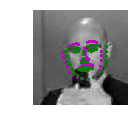

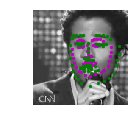

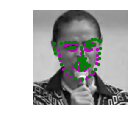

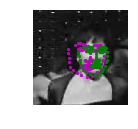

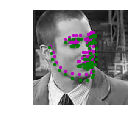

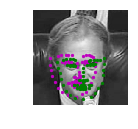

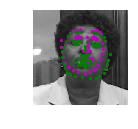

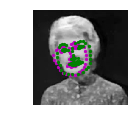

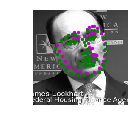

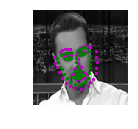

In [24]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [25]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
# model_name = 'keypoints_model_1.pt'
model_name = 'keypoints_model_NaimishResidualNet.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: <span style="color: red; "> Adam optimizer, with learning rate of 0.001, β1 of 0.9, β2 of 0.999 and ε of 1e−08, and  Mean Squared Error (MSE), as well as [the paper](https://arxiv.org/pdf/1710.00977.pdf) </span>

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: <span style="color: red; "> I started with NaimishNet from [the paper](https://arxiv.org/pdf/1710.00977.pdf) and finally I added Residual Connections to it.</span>

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: <span style="color: red; "> In [the reference paper](https://arxiv.org/abs/1606.02228), 128 batchsize and 300 epochs were used, but due to memory shortage and other reasons in the development environment, 32 batchsize and 30 epochs were selected for this project.</span>

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.15857244 -0.2544736  -0.05570424 -0.21309038]
 [ 0.09864224  0.09764277 -0.19676341 -0.23638439]
 [ 0.19040579 -0.05664296  0.13636914  0.09246971]
 [ 0.19745299  0.03312645  0.04626944  0.07052811]]
(4, 4)


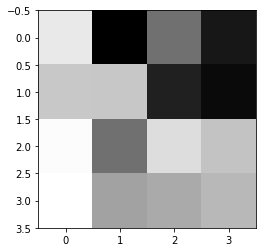

In [26]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

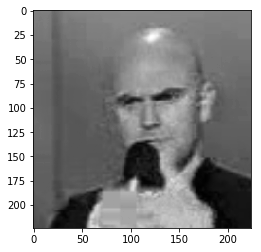

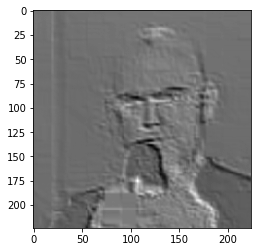

In [29]:
##TODO: load in and display any image from the transformed test dataset
# un-transform the image data
image = test_images[0].data   # get the image from it's Variable wrapper
image = image.cpu().numpy()   # convert to numpy array from a Tensor
image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
plt.figure()
plt.imshow(np.squeeze(image), cmap='gray')
        
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
import cv2
filtered_image = cv2.filter2D(image, -1, w[filter_index][0])
plt.figure()
plt.imshow(filtered_image, cmap='gray')


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: <span style="color: red; "> The filter detected edges around eyes. </span>

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!